In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'C:/Users/Chloé/Desktop/csulb/lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


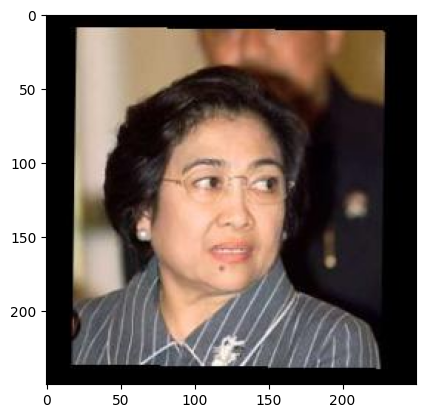

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

Autoencoders are used for data compression and feature learning, essentially shrinking data and then reconstructing it. They find applications in tasks like image denoising and dimensionality reduction. In contrast, Variational Autoencoders  enhance AEs by introducing a probabilistic approach. VAEs are particularly useful for generating new data points with similar characteristics to the training set, commonly applied in tasks like image generation. AEs consist of an encoder and decoder with a fixed mapping, while VAEs have a similar structure, but the encoder outputs a probability distribution over the latent space, adding a stochastic element. The loss function for AEs focuses on minimizing reconstruction errors, often using mean squared error. VAEs, in addition to a reconstruction term, include a regularization term that encourages a specific probability distribution in the latent space, promoting diverse and meaningful sample generation. In summary, AEs compress data, while VAEs add a probabilistic touch for more versatile data generation.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [6]:

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        
        self._to_linear = None
        self._calculate_flat_size((3, 250, 250))  
        
        self.fc1 = nn.Linear(self._to_linear, 1024)
        self.fc21 = nn.Linear(1024, 20)
        self.fc22 = nn.Linear(1024, 20)
        
        self.fc3 = nn.Linear(20, 1024)
        self.fc4 = nn.Linear(1024, 256*16*16)
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)
    
    def _calculate_flat_size(self, shape):
        with torch.no_grad():
            x = torch.ones(1, *shape)
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            self._to_linear = x.view(-1).shape[0]
            
    def encode(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.relu(self.conv4(x))
        x = x.view(-1, self._to_linear)
        x = nn.functional.relu(self.fc1(x))
        return self.fc21(x), self.fc22(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = nn.functional.relu(self.fc3(z))
        z = nn.functional.relu(self.fc4(z))
        z = z.view(-1, 256, 16, 16) 
        
        z = nn.functional.relu(self.deconv1(z))
        z = nn.functional.relu(self.deconv2(z))
        z = nn.functional.relu(self.deconv3(z))
    
        z = self.deconv4(z) 


        z = nn.functional.interpolate(z, size=(250, 250), mode='bilinear', align_corners=False)
        z = torch.sigmoid(z) 
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)


In [10]:
dataiter = iter(dataloader)
images, _ = next(dataiter)
images = images.to(device)


with torch.no_grad():
    model.eval()
    mu, logvar = model.encode(images[0].unsqueeze(0)) 
    print("Shape of the encoder's output (mu):", mu.shape)
    print("Shape of the encoder's output (logvar):", logvar.shape)

    samples = model.reparameterize(mu, logvar)
    print("Shape of the samples in the latent space:", samples.shape)
    generated_images = model.decode(samples)
    print("Shape of the decoder's output (generated images):", generated_images.shape)

Shape of the encoder's output (mu): torch.Size([1, 20])
Shape of the encoder's output (logvar): torch.Size([1, 20])
Shape of the samples in the latent space: torch.Size([1, 20])
Shape of the decoder's output (generated images): torch.Size([1, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [11]:
total_params = sum(p.numel() for p in model.parameters())
print("Total Parameters:", total_params)


Total Parameters: 127600363


In [12]:
import torch.optim as optim

optim = optim.Adam(model.parameters(), lr=0.001)

In [13]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [14]:
num_epochs = 6  

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_idx, (data, _) in enumerate(dataloader):
        optim.zero_grad()

        reconstructed_data, mu, logvar = model(data)
        
        recon_loss = loss_function(reconstructed_data, data)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        total_loss = recon_loss + kl_divergence

        
        total_loss.backward()
        optim.step()

        
        total_loss += total_loss.item()

    average_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")


Epoch [1/6], Loss: 9.509095434623305e-06
Epoch [2/6], Loss: 1.1973308573942631e-05
Epoch [3/6], Loss: 9.915573173202574e-06
Epoch [4/6], Loss: 1.2182831596874166e-05
Epoch [5/6], Loss: 1.1090537554991897e-05
Epoch [6/6], Loss: 9.859411875368096e-06


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

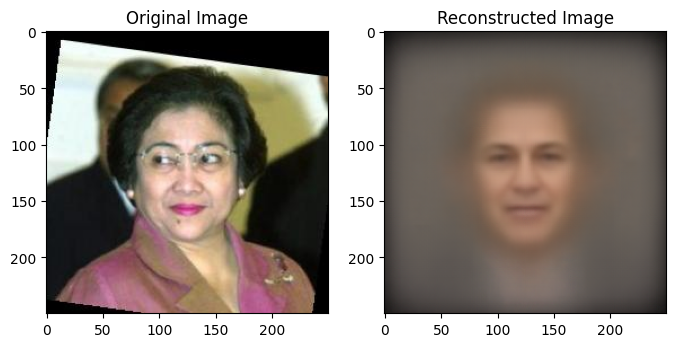

In [15]:
random_idx = np.random.randint(len(dataloader.dataset))
random_image, _ = dataloader.dataset[random_idx]

with torch.no_grad():
    model.eval()
    random_image = random_image.unsqueeze(0) 
    reconstructed_image, _, _ = model(random_image)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(np.transpose(random_image.squeeze().numpy(), (1, 2, 0)))
axes[0].set_title("Original Image")

axes[1].imshow(np.transpose(reconstructed_image.squeeze().numpy(), (1, 2, 0)))
axes[1].set_title("Reconstructed Image")

plt.show()